<a href="https://colab.research.google.com/github/realtechsupport/cocktail/blob/main/sandbox/notebooks/training_tfrecords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Brief Recap:

1. We have converted the tiff files into tf records and saved them as tf.records in drive
2. We have extracted the saved tf.records and conducted pre-processing.


In [18]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Phase 1: Extract tf records from the tiff files

In [ ]:
!pip install rasterio

#imports

import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import tensorflow as tf
import glob

In [8]:
#file locations

# Specify the folder path where your images are located
folder_path = '/content/gdrive/MyDrive/exp/other images/test_folder/'

# Specify the folder path where your labels are located
label_folder = '/content/gdrive/MyDrive/exp/label/'

#Specify the path where your clipping mask are located
geojson_datapath = '/content/gdrive/MyDrive/exp/label/newextent_1123.geojson'


#specify the tf.record path
output_dir = '/content/gdrive/MyDrive/exp/tf_records/'

Clipping, Resizing, Conversion to tf.record functions

In [4]:
def clip_tiff(tiff, geojson = geojson_datapath):

    with open(geojson) as clip_geojson:
        clip_geojson = gpd.read_file(clip_geojson)
        clip_geometry = clip_geojson.geometry.values[0]
        clip_geojson = mapping(clip_geometry)
        #print(clip_geojson)

    with rasterio.open(tiff) as src:
        #print("input image data before processing", src.meta)

        # Perform the clip
        clip_image, clip_transform = mask(src, [clip_geojson], crop=True)
        #print("shape of clipped_image:", clip_image.shape)
        #print("extent of clipped image:", clip_transform)
        #clip_meta = src.meta.copy()

    # clip_meta.update({"driver": "GTiff",
    #                   "height": clip_image.shape[1],
    #                   "width": clip_image.shape[2],
    #                   "transform": clip_transform})
    return clip_image

# preprocessing functions

def resize_img(image,label):

  image = tf.image.resize_with_crop_or_pad(image, label.shape[0], label.shape[1])

  return image, label


def process_input(image, label):

    tensor_image = tf.convert_to_tensor(image)
    tensor_image = tf.transpose(tensor_image, perm=[1, 2, 0])
    tensor_label = tf.convert_to_tensor(label)
    tensor_label = tf.transpose(tensor_label, perm=[1, 2, 0])

    if tensor_label.shape[:2] != tensor_image.shape[:2]:
      tensor_image, tensor_label = resize_img(tensor_image, tensor_label)

    return tensor_image, tensor_label


def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def create_tfrecord(image, label):
    image = clip_tiff(image)
    label = clip_tiff(label)
    image, label = process_input(image, label)
    image_dims = image.shape
    label_dims = label.shape

    image = tf.reshape(image, [-1])  # flatten to 1D array
    label = tf.reshape(label, [-1])  # flatten to 1D array

    return tf.train.Example(
        features=tf.train.Features(
            feature={
                "image": _float_feature(image.numpy()),
                "image_shape": _int64_feature(
                    [image_dims[0], image_dims[1], image_dims[2]]
                ),
                "label": _float_feature(label.numpy()),
                "label_shape": _int64_feature([label_dims[0], label_dims[1], label_dims[2]]),
            }
        )
    ).SerializeToString()

In [6]:
images = glob.glob(folder_path + '*.tif') #list of filelocations of all images

number_of_images = len(images)

labels = glob.glob(label_folder + '*.tif')

labels = labels*number_of_images


In [21]:
def write_tfrecords2(images, labels, output_directory):
    os.makedirs(output_directory, exist_ok=True)
    for image, label in zip(images, labels):
        output_file = os.path.join(output_directory, f"{image.replace(folder_path,'').replace('.tif','')}_tfrecord.tfrecord")
        #print(output_file)
        with tf.io.TFRecordWriter(output_file) as writer:
            tf_example = create_tfrecord(image, label)
            writer.write(tf_example)


write_tfrecords2(images, labels, output_dir)


/content/gdrive/MyDrive/exp/tf_records/area2_0803_2022_8bands_tfrecord.tfrecord
/content/gdrive/MyDrive/exp/tf_records/area2_0619_2023_8bands_composite_tfrecord.tfrecord


In [ ]:
# def create_dataset(tfrecords_dir):
#   tfrecord_files = [os.path.join(input_directory, file) for file in os.listdir(input_directory) if file.endswith('.tfrecord')]
#   dataset = tf.data.TFRecordDataset(tfrecord_files)
#   dataset = dataset.map(parse_tfr)
#   return dataset

# Phase 2: Convert the image-label pair to image-patch and label-patch tensors and prepare to load into model

In [2]:
input_directory = '/content/gdrive/MyDrive/exp/tf_records/'

In [3]:
import tensorflow as tf
import os

In [4]:
feature_description = {
    "image": tf.io.VarLenFeature(tf.float32),
    "image_shape": tf.io.VarLenFeature(tf.int64),
    "label": tf.io.VarLenFeature(tf.float32),
    "label_shape": tf.io.VarLenFeature(tf.int64),
}

def parse(serialized_examples):
    return tf.io.parse_example(serialized_examples, feature_description)


In [5]:
def create_dataset(tfrecords_dir):
  tfrecord_files = [os.path.join(input_directory, file) for file in os.listdir(input_directory) if file.endswith('.tfrecord')]
  dataset = tf.data.TFRecordDataset(tfrecord_files)
  dataset = dataset.map(parse)
  return dataset

In [6]:
#pre-processing functions

def bandwise_normalize(input_tensor, epsilon=1e-8):
    # Calculate the minimum and maximum values along the channel axis
    min_val = tf.math.reduce_min(input_tensor, axis=2, keepdims=True)
    max_val = tf.math.reduce_max(input_tensor, axis=2, keepdims=True)

    # Check for potential numerical instability
    denom = max_val - min_val
    denom = tf.where(tf.abs(denom) < epsilon, epsilon, denom)

    # Normalize the tensor band-wise to the range [0, 1]
    normalized_tensor = (input_tensor - min_val) / denom

    return normalized_tensor

def pad_to_multiple(image, TILE_HT, TILE_WD):
    # Get the current dimensions
    height, width, channels = image.shape

    # Calculate the target dimensions
    target_height = tf.cast(tf.math.ceil(height / TILE_HT) * TILE_HT, tf.int32)
    target_width = tf.cast(tf.math.ceil(width / TILE_WD) * TILE_WD, tf.int32)

    # Calculate the amount of padding
    pad_height = target_height - height
    pad_width = target_width - width

    # Pad the image
    padded_image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)

    return padded_image

def tile_image(fullimg, CHANNELS=1, TILE_HT=128, TILE_WD=128):
    fullimg = pad_to_multiple(fullimg, TILE_HT, TILE_WD)
    images = tf.expand_dims(fullimg, axis=0)
    tiles = tf.image.extract_patches(
        images=images,
        sizes=[1, TILE_HT, TILE_WD, 1],
        strides=[1, TILE_HT, TILE_WD, 1],
        rates=[1, 1, 1, 1],
        padding='VALID')
    #print(tiles.shape)

    tiles = tf.squeeze(tiles, axis=0)
    nrows = tiles.shape[0]
    ncols = tiles.shape[1]
    #print(tiles.shape)
    tiles = tf.reshape(tiles, [nrows, ncols, TILE_HT, TILE_WD, CHANNELS])
    print(tiles.shape)
    return tiles

def sampling(label_image, threshold_percentage = 99.9):

    num_zeros = tf.reduce_sum(tf.cast(tf.equal(label_image, 0), tf.float32), axis=[2, 3, 4])

    # Calculate the total number of elements in each patch
    total_elements = tf.cast(tf.reduce_prod(tf.shape(label_image)[2:]), tf.float32)

    # Calculate the percentage of zeros in each patch
    percentage_zeros = (num_zeros / total_elements) * 100.0

    boolean_mask = percentage_zeros <= threshold_percentage
    # Apply the threshold logic
    sampled_tensor = tf.cast(percentage_zeros >= threshold_percentage, tf.int32)

    return boolean_mask, sampled_tensor

def one_hot_encoding(label_tensor):
    # Assuming your pixel values are float labels
    float_labels = tf.squeeze(label_tensor, axis=-1)  # Assuming channel dimension is the last one

    # Determine the number of classes dynamically
    num_classes = tf.cast(tf.reduce_max(float_labels) + 1, tf.int32)

    # One-hot encode each image
    one_hot_encoded_images = tf.one_hot(tf.dtypes.cast(float_labels, tf.int32), depth=num_classes)

    # Print the shape of the resulting tensor and the number of classes
    #print("Shape of one-hot encoded images:", one_hot_encoded_images.shape)
    #print("Number of classes:", num_classes)

    return one_hot_encoded_images


In [8]:
dataset = create_dataset(input_directory)

In [9]:
image_patch_tensors_list = []
label_patch_tensors_list = []

for parsed_example in dataset:

    image_shape = tf.sparse.to_dense(parsed_example["image_shape"])
    image = tf.reshape(tf.sparse.to_dense(parsed_example["image"]), image_shape)
    label_shape = tf.sparse.to_dense(parsed_example["label_shape"])
    label = tf.reshape(tf.sparse.to_dense(parsed_example["label"]), label_shape)

    #image normalization
    image = bandwise_normalize(image)

    #image and label patching
    image_patches = tile_image(image,8,256,256)
    label_patches = tile_image(label,1,256,256)

    #sampling
    sampled_mask, sampled_tensor = sampling(label_patches)
    sampled_image_patches = tf.boolean_mask(image_patches, sampled_mask)
    sampled_label_patches = tf.boolean_mask(label_patches, sampled_mask)

    #one-hot encoding
    sampled_label_patches = one_hot_encoding(sampled_label_patches)

    #save them in the list
    image_patch_tensors_list.append(sampled_image_patches)
    label_patch_tensors_list.append(sampled_label_patches)


# Combine images and labels from different pairs
combined_images = tf.concat(image_patch_tensors_list, axis=0)
combined_labels = tf.concat(label_patch_tensors_list, axis=0)

# Shuffle the combined data
combined_dataset = tf.data.Dataset.from_tensor_slices((combined_images, combined_labels))
combined_dataset = combined_dataset.shuffle(buffer_size=combined_images.shape[0])

#Split the combined dataset into training and validation sets
train_size = int(0.8 * combined_images.shape[0])
train_dataset = combined_dataset.take(train_size)
val_dataset = combined_dataset.skip(train_size)

#Batch the data using TensorFlow's Dataset API
batch_size = 32  # Choose an appropriate batch size
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)


(15, 18, 256, 256, 8)
(15, 18, 256, 256, 1)
(15, 18, 256, 256, 8)
(15, 18, 256, 256, 1)


# Phase 3: train a model with the prepared dataset

In [12]:
from tensorflow import keras
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (8,))
    x = inputs

    # Encoder
    conv1 = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    conv1 = layers.Conv2D(16, 3, activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(32, 3, activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(32, 3, activation="relu", padding="same")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(64, 3, activation="relu", padding="same")(pool2)
    conv3 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv3)

    # Decoder
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    concat4 = layers.Concatenate()([up4, conv2])
    conv4 = layers.Conv2D(32, 3, activation="relu", padding="same")(concat4)
    conv4 = layers.Conv2D(32, 3, activation="relu", padding="same")(conv4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat5 = layers.Concatenate()([up5, conv1])
    conv5 = layers.Conv2D(16, 3, activation="relu", padding="same")(concat5)
    conv5 = layers.Conv2D(16, 3, activation="relu", padding="same")(conv5)

    # Output
    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(conv5)

    model = keras.Model(inputs, outputs)
    return model

In [13]:
patch_size = 256
img_size = (patch_size, patch_size)
num_classes = 23
model = get_model(img_size=img_size, num_classes=num_classes)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 8)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         1168      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [14]:
model.compile(optimizer="adam", loss="categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("tf_record_model.hdf5",
                                    save_best_only=True)
]

model_history = model.fit(train_dataset,
                    epochs=5,
                    callbacks=callbacks,
                    batch_size=32,
                    validation_data= val_dataset)

model.save('/content/gdrive/MyDrive/exp/tf_record_model.hdf5')


Epoch 1/5
6/6 [==============================] - ETA: 0s - loss: 3.0289 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 118s 18s/step - loss: 3.0289 - val_loss: 2.3075
Epoch 2/5
6/6 [==============================] - 106s 17s/step - loss: 1.4349 - val_loss: 1.4494
Epoch 3/5
6/6 [==============================] - 110s 18s/step - loss: 0.8624 - val_loss: 0.8604
Epoch 4/5
6/6 [==============================] - 107s 17s/step - loss: 0.6714 - val_loss: 0.7488
Epoch 5/5
6/6 [==============================] - 120s 20s/step - loss: 0.5631 - val_loss: 0.4779


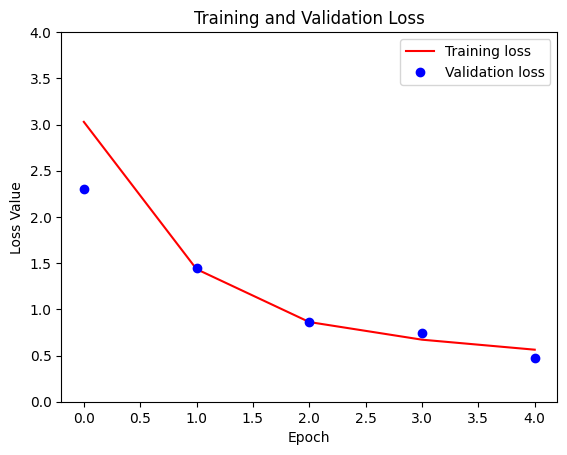

In [17]:
import matplotlib.pyplot as plt

# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = 5
epochs = range(epochs)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 4])
plt.legend()
plt.show()

# Phase 4: Metrics and Evaluation

# Phase 5: Prediction